In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, callbacks, regularizers
from tensorflow.keras.losses import MeanSquaredError

# Data wrangling

In [2]:
# Load datasets:
train_seq = pd.read_csv("train_sequences.csv")
train_lab = pd.read_csv("train_labels.csv")
val_seq = pd.read_csv("validation_sequences.csv")
val_lab = pd.read_csv("validation_labels.csv")

In [3]:
# Quick look at the data:
for data in [train_seq, train_lab, val_seq, val_lab]:
    display(data[:3])

,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...


,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878


,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_37,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40
0,R1107_1,G,1,-5.499,8.520,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
1,R1107_2,G,2,-5.826,10.453,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
2,R1107_3,G,3,-5.849,14.768,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18


In [4]:
#removing resid-numbers from the IDs
for df in [train_lab, val_lab]:
    df['ID'] = df['ID'].str.extract('(.*)_[\d]+$')

In [5]:
for data in [train_lab, val_lab]:
    display(data[:3])

,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A,G,1,13.760,-25.974001,0.102
1,1SCL_A,G,2,9.310,-29.638000,2.669
2,1SCL_A,G,3,5.529,-27.813000,5.878


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_37,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40
0,R1107,G,1,-5.499,8.520,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
1,R1107,G,2,-5.826,10.453,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
2,R1107,G,3,-5.849,14.768,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18


In [6]:
#cheching for 0 values in train_ and val_lab datasets:
for data in [train_lab, val_lab]:
    display(data.isnull().sum())

ID            0
resname       0
resid         0
x_1        6145
y_1        6145
z_1        6145
dtype: int64

ID         0
resname    0
resid      0
x_1        0
y_1        0
          ..
y_39       0
z_39       0
x_40       0
y_40       0
z_40       0
Length: 123, dtype: int64

The **train_lab** (training labels) dataset has 6145 rows with empty x_1, y_1, z_1 coordinates 😱 <br />
Let's select sequences without empty coordinates:

In [7]:
#Checking for sequences with complete x_1, y_1, z_1 coordinates:
notempty_ids = []
for ID in train_lab.ID.unique():
    x_1 = train_lab[train_lab.ID == ID].x_1
    if x_1.notnull().all():
        notempty_ids.append(ID)

print(f"There are {len(notempty_ids)} sequences with complete x_1, y_1, z_1 coordinates.")

#selecting sequences with known x_1, y_1, z_1 coordinates:
train_lab = train_lab[train_lab.ID.isin(notempty_ids)]

There are 606 sequences with complete x_1, y_1, z_1 coordinates.


In [8]:
#checking if there are still nucleotides other than 'G', 'U', 'C', 'A':
train_lab.resname.unique()

array(['G', 'U', 'C', 'A'], dtype=object)

### Length selection

In [9]:
train_seq[:3] #just to have in front of the eyes

,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...


count     844.000000
mean      162.434834
std       515.031957
min         3.000000
25%        22.000000
50%        39.500000
75%        86.000000
max      4298.000000
Name: sequence, dtype: float64


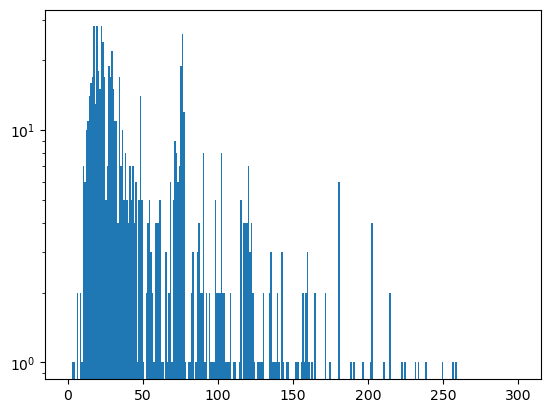

In [10]:
#lenght distribution

print(train_seq.sequence.str.len().describe())

plt.figure()
_ = plt.hist(train_seq.sequence.str.len(), 300, log=True, range = (0, 300))

In [11]:
selected_length = 250 #slightly higer than mean

### Operations on RNA sequences

**Train_** and **val_labels** have all information needed: <br />  
 - RNA `ID`'s;
 - coordinates `x_1`, `y_1`, `z_1`;
 - sequences can be built stepwise, nucleotide-by-nucleotide, from `resname`'s (using given ***selected_length***)

To save currecnt sequence, I'll add a `sequence` column to **train_** and **val_labels** .

In [12]:
#nucleotide encoding
def encode_sequence(resname):
    mapping = {'A': 8, 'U': 2, 'G': 6, 'C': 4}
    return mapping[resname]

train_lab.resname = train_lab.resname.apply(encode_sequence)
val_lab.resname = val_lab.resname.apply(encode_sequence)

In [13]:
#building stepwise (encoded) nucleotide sequence
def add_nucleotide_to_sequence(lab):

    sequence = []

    for ID in lab.ID.unique():

        #defining how long the sequence should be (lenght defined before: selected_length)
        #strating sequence has all encoded nucleotides as zeros
        add_codon = np.zeros(selected_length,)
        rows = lab[lab.ID == ID]

        # if sequence is smaller than selected_length:
        for n in range(min(len(rows), selected_length)):
            add_codon[n] = rows.resname.iloc[n]
            sequence.append(add_codon.copy())

        # if sequence is larger than selected_length:
        for n in range(selected_length, len(rows)):
            add_codon[:-1] = add_codon[1:]
            add_codon[-1] = rows.resname.iloc[n]
            sequence.append(add_codon.copy())

    lab['sequence'] = sequence #addidng a sequence colum to save the current sequence

add_nucleotide_to_sequence(train_lab)
add_nucleotide_to_sequence(val_lab)

In [14]:
train_lab.head() #what it should look like in the end

,ID,resname,resid,x_1,y_1,z_1,sequence
0,1SCL_A,6,1,13.760,-25.974001,0.102,"[6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1SCL_A,6,2,9.310,-29.638000,2.669,"[6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1SCL_A,6,3,5.529,-27.813000,5.878,"[6.0, 6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1SCL_A,2,4,2.678,-24.900999,9.793,"[6.0, 6.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1SCL_A,6,5,1.827,-20.136000,11.793,"[6.0, 6.0, 6.0, 2.0, 6.0, 0.0, 0.0, 0.0, 0.0, ..."


###  Normalization

By normalization, I mean the following:
1. All RNA sequences should have the same starting point, which is 0;
2. All RNA sequences should be in the same direction (e.g., the second nucleotide should have positive xyz coordinates);
3. Scaling using MinMaxScaler

In [15]:
def normalizing_coords(lab):

    for ID in lab.ID.unique():

        for c in ['x_1', 'y_1', 'z_1']:

            #normalization_1: shifting xyz coordinates that the 1st coordinate is 0, rest accordinly
            lab.loc[lab.ID == ID, c] -= lab.loc[lab.ID == ID, c].iloc[0]
            # normalization_2: mirrowing if any 2nd xyz coordinate(s) is/are negative
            lab.loc[lab.ID == ID, c] *= np.sign(lab.loc[lab.ID == ID, c].iloc[1])

normalizing_coords(train_lab)
normalizing_coords(val_lab)

In [16]:
train_lab[:3]

,ID,resname,resid,x_1,y_1,z_1,sequence
0,1SCL_A,6,1,-0.000,-0.000000,0.000,"[6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1SCL_A,6,2,4.450,3.664000,2.567,"[6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1SCL_A,6,3,8.231,1.838999,5.776,"[6.0, 6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
x_train = np.array(train_lab.sequence.to_list())
y_train = train_lab[['x_1','y_1', 'z_1']]

x_val = np.array(val_lab.sequence.to_list())
y_val = val_lab[['x_1','y_1', 'z_1']]

# TensorFlow model

In [18]:
model = Sequential(
    [
        Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l1(0.0001)),
        Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l1(0.0001)),
        Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l1(0.0001)),
        Dense(3, activation = 'relu', kernel_regularizer=regularizers.l1(0.0001))
    ]
)

In [20]:
model.compile(loss = "MeanSquaredError",
              optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0007),
              metrics=['accuracy'])

model.fit(
     x_train, y_train,
     validation_data = (x_val, y_val),
     epochs = 100,
     verbose = 0)

print(f"Max validation accuracy: {(max(model.history.history['val_accuracy'])):.2f}")



Max validation accuracy: 0.55


# Prediction 

In [25]:
# ---- Define your custom input sequence ----
custom_sequence = "GGGUA"
sequence_id = "1SCL_A"  # or any string to tag this run

# ---- Build input DataFrame ----
def create_custom_input_df(sequence, sequence_id):
    n = len(sequence)
    df = pd.DataFrame({
        "ID": [f"{sequence_id}"] * n,
        "resname": list(sequence),
        "resid": list(range(1, n + 1))
    })
    return df

# ---- Prepare and Predict ----
df = create_custom_input_df(custom_sequence, sequence_id)

# --- Encode sequence ---
df['resname'] = df['resname'].apply(encode_sequence)

# --- Create windowed sequence ---
add_nucleotide_to_sequence(df)  # this adds a new `sequence` column

# --- Convert to model input ---
x_input = np.array(df['sequence'].to_list())

# --- Predict coordinates ---
y_pred = model.predict(x_input)  # shape: (n, 3*atoms)

# --- Format the output ---
n_atoms = y_pred.shape[1] // 3
coord_columns = [f"{axis}" for i in range(1, n_atoms+1) for axis in ["x", "y", "z"]]
coords_df = pd.DataFrame(y_pred, columns=coord_columns)

# --- Combine with metadata ---
final_output = pd.concat([df[["ID", "resname", "resid", "sequence"]], coords_df], axis=1)

# ---- Done! ----
print(final_output.head())

1/1 [==============================] - 0s 52ms/step
       ID  resname  resid                                           sequence  \
0  1SCL_A        6      1  [6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  1SCL_A        6      2  [6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  1SCL_A        6      3  [6.0, 6.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  1SCL_A        2      4  [6.0, 6.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  1SCL_A        8      5  [6.0, 6.0, 6.0, 2.0, 8.0, 0.0, 0.0, 0.0, 0.0, ...   

          x         y         z  
0  0.000000  0.000000  0.000000  
1  3.069310  2.727004  3.462676  
2  5.090862  4.950042  4.738385  
3  6.021756  5.947459  5.228395  
4  5.087852  8.957398  9.736097  
